<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/Deep_Convolutional_GAN_(DCGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu() #here must be cpu, not cuda
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#Generator

In [6]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
      super(Generator, self).__init__()
      self.z_dim = z_dim
        # Build the neural network
      self.gen = nn.Sequential(
          self.make_gen_block(z_dim, hidden_dim * 4),
          self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
          self.make_gen_block(hidden_dim * 2, hidden_dim),
          self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
        
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
      return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
      '''
      Function for completing a forward pass of the generator: Given a noise tensor, 
      returns generated images.
      Parameters:
        noise: a noise tensor with dimensions (n_samples, z_dim)
      '''
      x = self.unsqueeze_noise(noise)
      return self.gen(x)

In [4]:
def get_noise(n_samples, z_dim, device='cuda'):
  '''
  Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
  creates a tensor of that shape filled with random numbers from the normal distribution.
  Parameters:
  n_samples: the number of samples to generate, a scalar
  z_dim: the dimension of the noise vector, a scalar
  device: the device type
      '''
  return torch.randn(n_samples, z_dim, device=device)

#Discriminator

In [7]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

#Training <p>


*   criterion: the loss function
*   n_epochs: the number of times you iterate through the entire dataset when training
*   z_dim: the dimension of the noise vector
*   display_step: how often to display/visualize the images
*   batch_size: the number of images per forward/backward pass
*   lr: the learning rate
*   beta_1, beta_2: the momentum term
*   device: the device type

In [8]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course!
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# You initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Step 500: Generator loss: 0.9466506190299986, discriminator loss: 0.5022904076576234


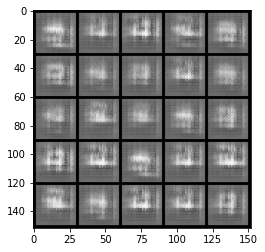

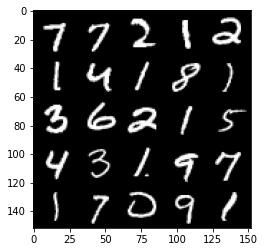

Step 1000: Generator loss: 1.3320466020107244, discriminator loss: 0.47370091861486413


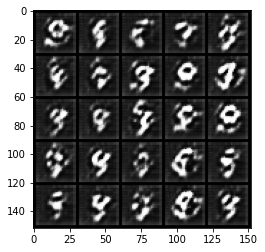

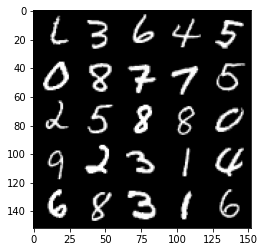

Step 1500: Generator loss: 0.9665217039585106, discriminator loss: 0.5857291021347044


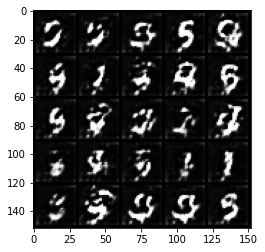

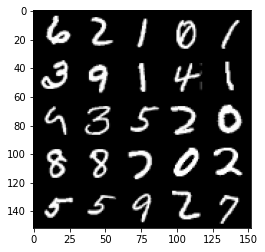

Step 2000: Generator loss: 0.8586946359276767, discriminator loss: 0.6262287868261337


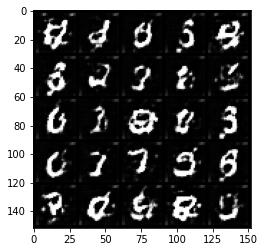

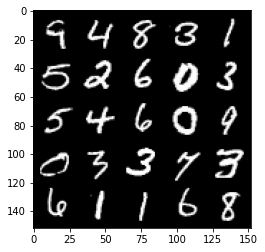

Step 2500: Generator loss: 0.8111767836213118, discriminator loss: 0.6444441769123079


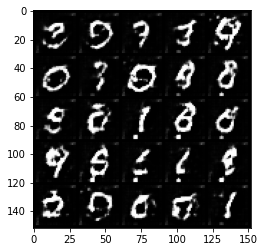

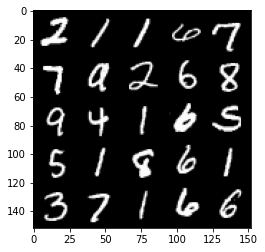

Step 3000: Generator loss: 0.7857776085138327, discriminator loss: 0.6487995660305025


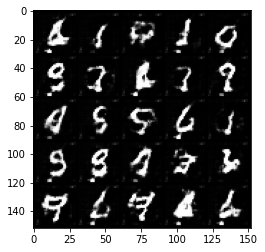

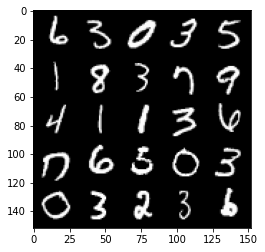

Step 3500: Generator loss: 0.7734837985038754, discriminator loss: 0.6554750446081173


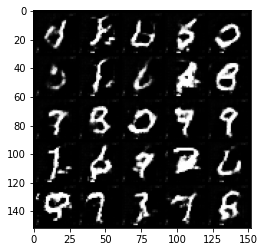

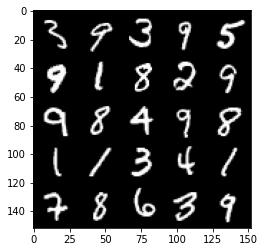

Step 4000: Generator loss: 0.763446845889091, discriminator loss: 0.6671214828491207


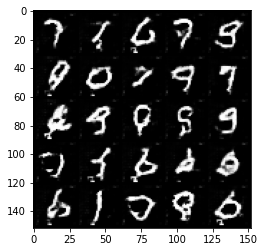

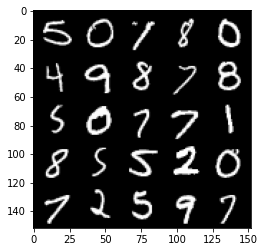

Step 4500: Generator loss: 0.7595190443992617, discriminator loss: 0.6718638504743568


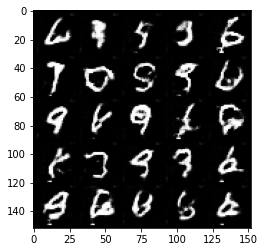

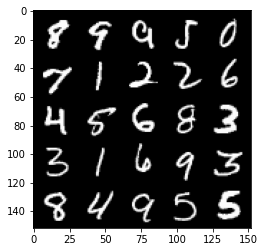

Step 5000: Generator loss: 0.7476860046982761, discriminator loss: 0.6761270545721054


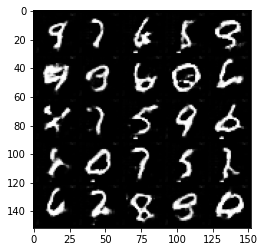

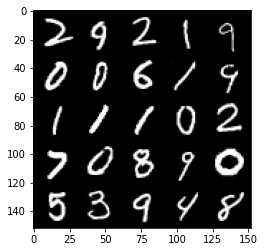

Step 5500: Generator loss: 0.7426436575055124, discriminator loss: 0.6780954514741901


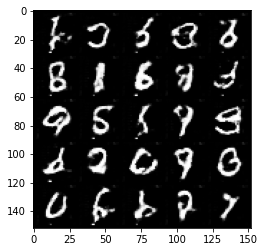

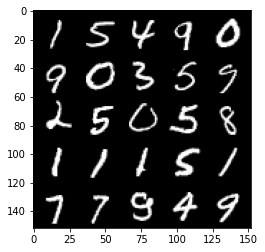

Step 6000: Generator loss: 0.7387039498686786, discriminator loss: 0.6807005841732031


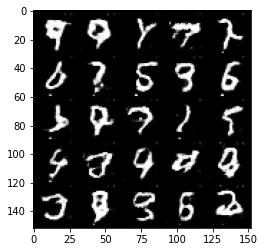

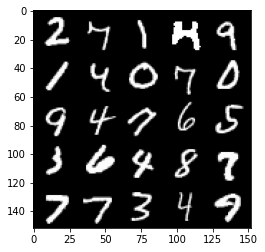

Step 6500: Generator loss: 0.7384734386801712, discriminator loss: 0.6816593600511547


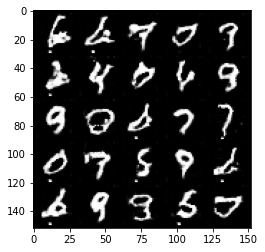

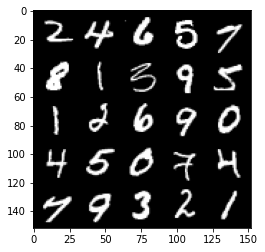

Step 7000: Generator loss: 0.7354579861760145, discriminator loss: 0.6818568626642231


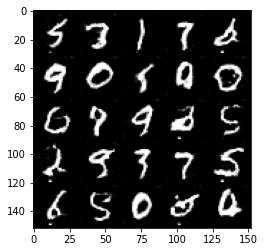

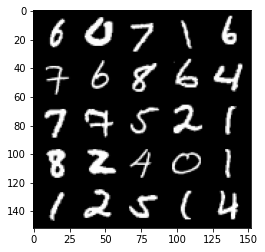

Step 7500: Generator loss: 0.7335404180288319, discriminator loss: 0.6840642340183257


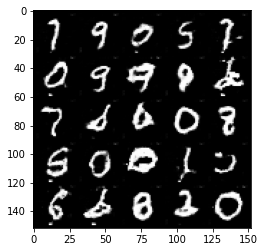

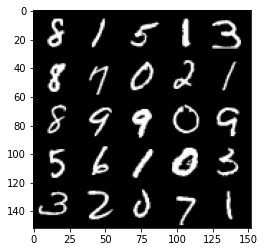

Step 8000: Generator loss: 0.7329524267315858, discriminator loss: 0.6842380162477495


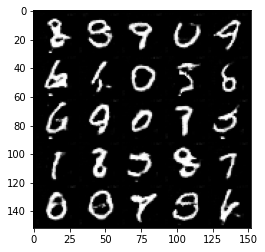

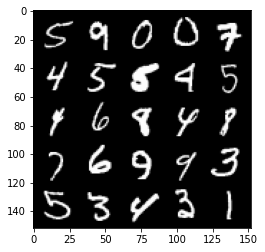

Step 8500: Generator loss: 0.729161354064942, discriminator loss: 0.6846317602396014


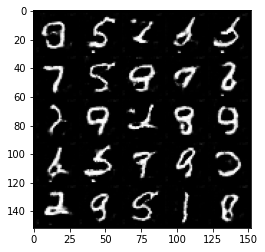

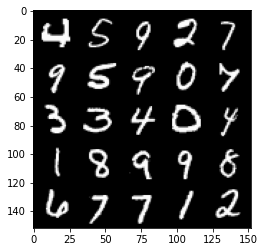

Step 9000: Generator loss: 0.7298922972083087, discriminator loss: 0.6851226930618282


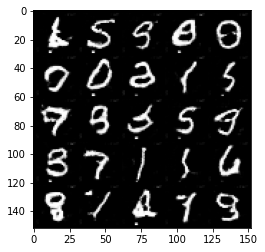

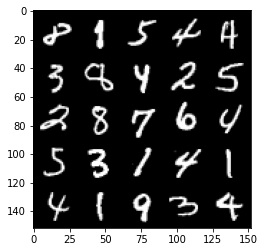

Step 9500: Generator loss: 0.7273573537468918, discriminator loss: 0.6878163967132562


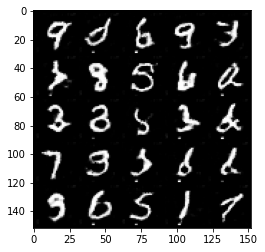

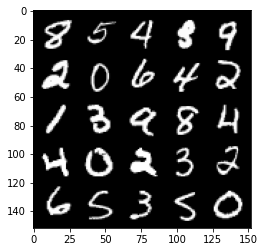

Step 10000: Generator loss: 0.7264599856734273, discriminator loss: 0.6875760426521302


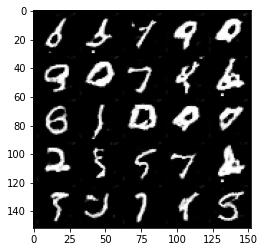

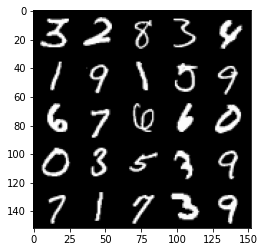

Step 10500: Generator loss: 0.7229853575229647, discriminator loss: 0.6892821421623229


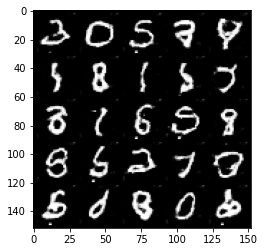

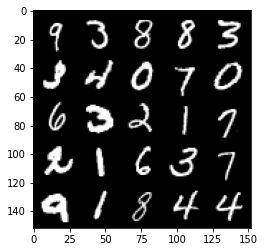

Step 11000: Generator loss: 0.7194349250197412, discriminator loss: 0.6891412488222114


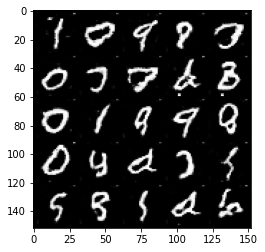

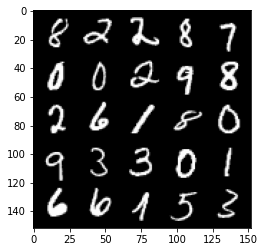

Step 11500: Generator loss: 0.718425063312054, discriminator loss: 0.689813777565956


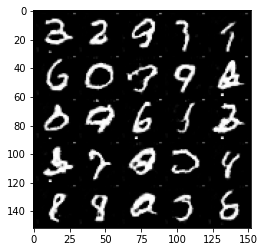

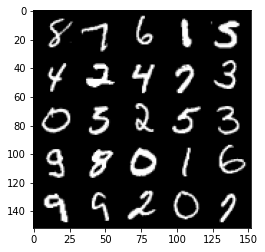

Step 12000: Generator loss: 0.7203182596564299, discriminator loss: 0.6897448309659956


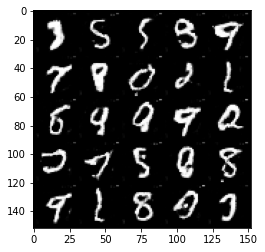

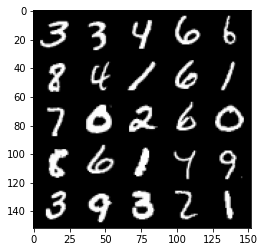

Step 12500: Generator loss: 0.7200309757590294, discriminator loss: 0.6905509330034255


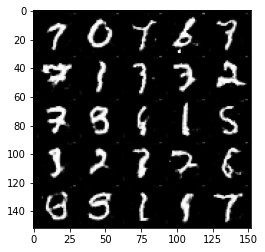

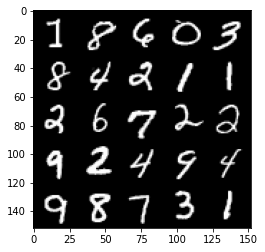

Step 13000: Generator loss: 0.7176823821067816, discriminator loss: 0.6902517443895342


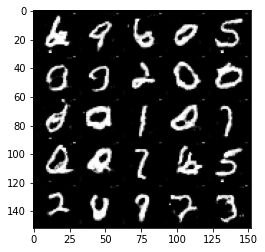

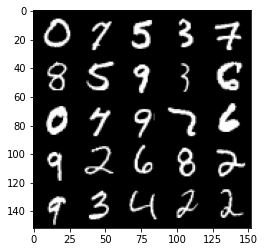

Step 13500: Generator loss: 0.714183044016361, discriminator loss: 0.6933813081979762


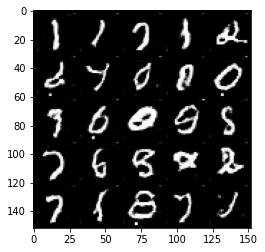

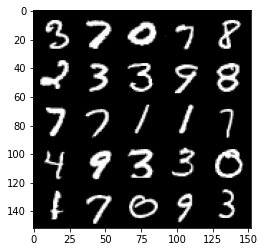

Step 14000: Generator loss: 0.7104712691307069, discriminator loss: 0.6918873765468596


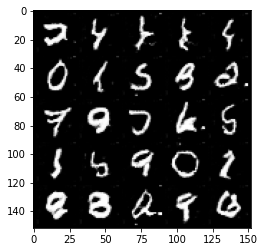

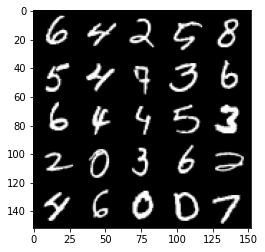

Step 14500: Generator loss: 0.7108317021131516, discriminator loss: 0.6936384818553926


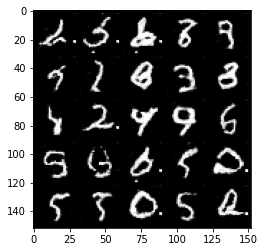

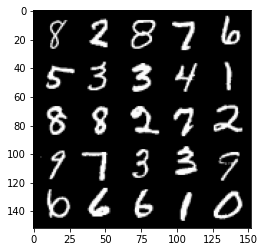

Step 15000: Generator loss: 0.7110790221691139, discriminator loss: 0.6937370890378947


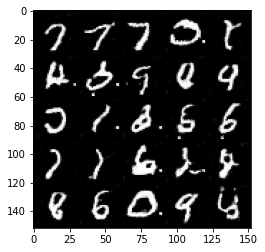

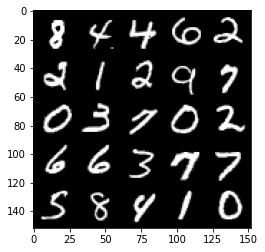

Step 15500: Generator loss: 0.707747869551182, discriminator loss: 0.6954879732131963


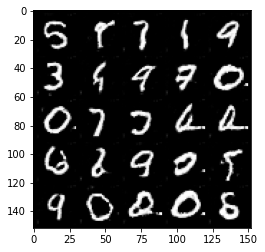

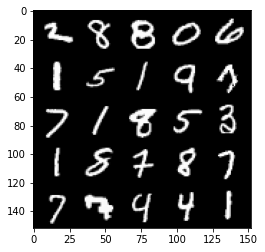

Step 16000: Generator loss: 0.7083676526546486, discriminator loss: 0.695210431694985


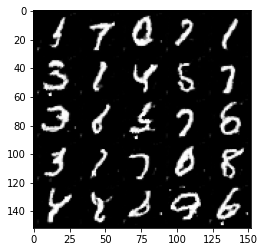

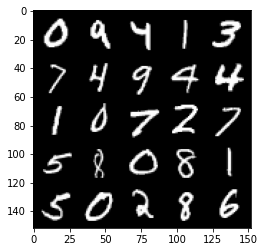

Step 16500: Generator loss: 0.7052990987896918, discriminator loss: 0.6948629561662677


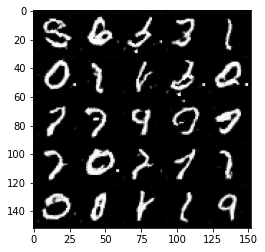

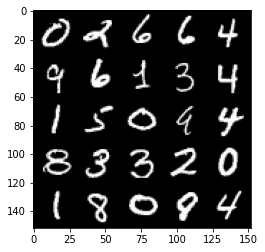

Step 17000: Generator loss: 0.7061677926778789, discriminator loss: 0.6949273505210875


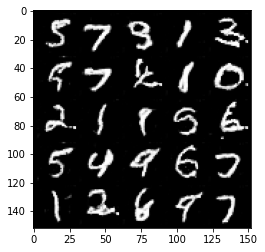

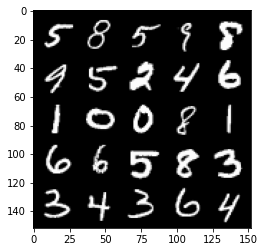

Step 17500: Generator loss: 0.7052362427711475, discriminator loss: 0.6956152977943423


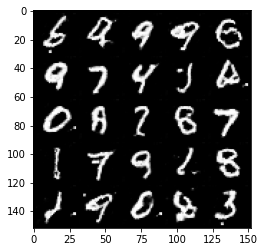

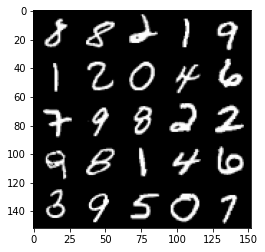

Step 18000: Generator loss: 0.7029460585117336, discriminator loss: 0.695430062055588


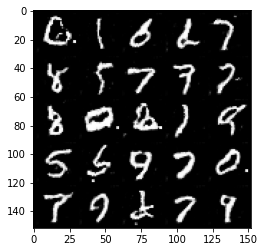

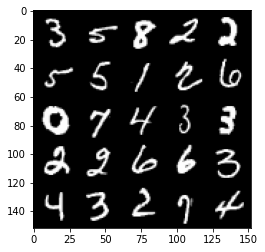

Step 18500: Generator loss: 0.7037273836135861, discriminator loss: 0.6942797328233713


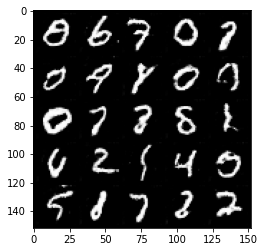

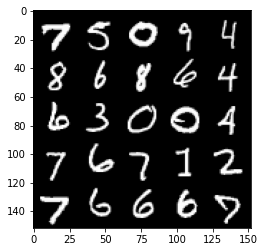

Step 19000: Generator loss: 0.7031789946556092, discriminator loss: 0.6947246266603472


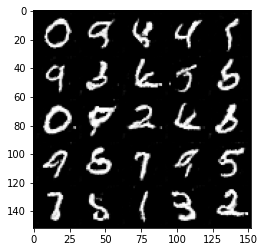

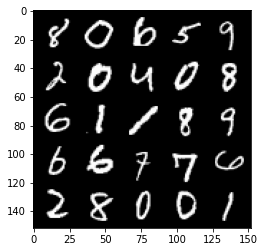

Step 19500: Generator loss: 0.701781803488731, discriminator loss: 0.6951183547973638


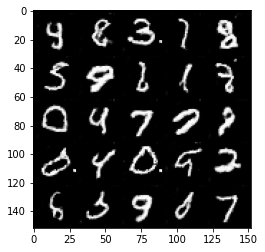

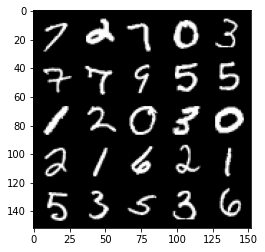

Step 20000: Generator loss: 0.702300419092179, discriminator loss: 0.694655202388764


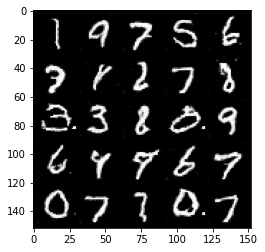

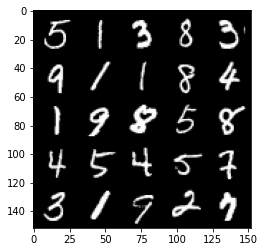

Step 20500: Generator loss: 0.7012400921583184, discriminator loss: 0.695060820698739


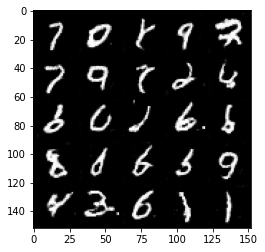

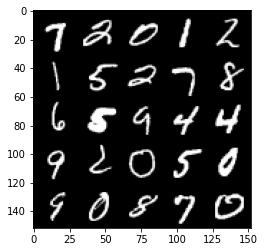

Step 21000: Generator loss: 0.7019033174514772, discriminator loss: 0.6946647695302961


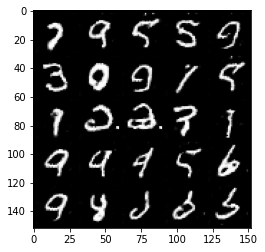

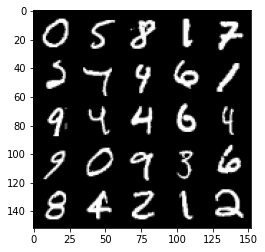

Step 21500: Generator loss: 0.6985743153095247, discriminator loss: 0.694985755205154


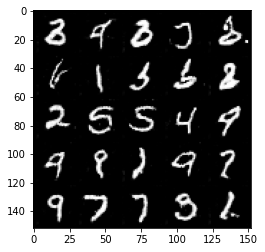

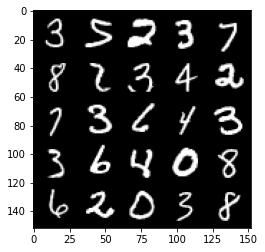

Step 22000: Generator loss: 0.6997243641614916, discriminator loss: 0.6958799086809158


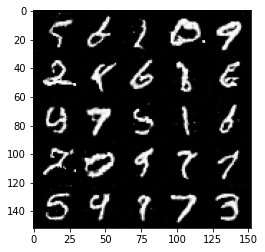

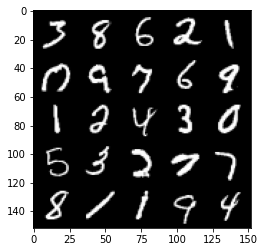

Step 22500: Generator loss: 0.6989134604930881, discriminator loss: 0.6948395379781721


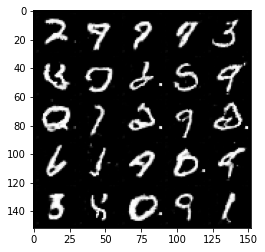

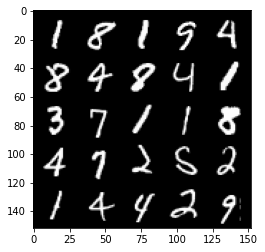

Step 23000: Generator loss: 0.6993468514680861, discriminator loss: 0.6946206166744235


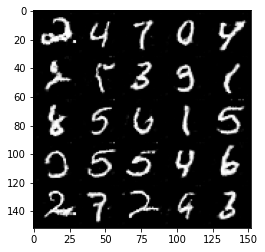

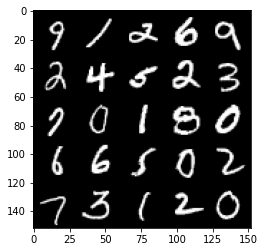

In [10]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1